In [23]:
import os, random, shutil

def randomize_datasets(pvTrain, pvTest, pvValid, path, typeML):
    
    totalFiles = len(next(os.walk(path+typeML))[2])
    trainMove = 0
    testMove = 0
    validMove = 0
    
    
    # n%20 < 16 put in folder train
    # elif x%20 < 19 put in folder test
    # else (x%20 == 19) put in folder verify
    
    print ("Moving {0} files...".format(totalFiles))
    x = 0
    while (x!=totalFiles):
        random.seed();
        for root, dirs, files in os.walk(path+typeML):
            for name in files:
                chance = random.uniform(0,99)
                rfile=os.path.join(root, name)    

                if (chance % 100 < pvValid):
                    shutil.move(rfile, path+'/valid/'+typeML+'/')
                    validMove = validMove + 1
                elif (chance % 100 < pvValid + pvTest):
                    shutil.move(rfile, path+'/test/'+typeML+'/')
                    testMove = testMove + 1
                else:
                    shutil.move(rfile, path+'/train/'+typeML+'/')
                    trainMove = trainMove + 1
                x = x + 1
        
    print ("Moved {0} to train!".format(trainMove))
    print ("Moved {0} to test!".format(testMove))
    print ("Moved {0} to valid!".format(validMove))
 


    
randomize_datasets(80, 15, 5, '/home/aashinshazar/beta/cookiesinthejar/', 'bad')
randomize_datasets(80, 15, 5, '/home/aashinshazar/beta/cookiesinthejar/', 'good')


Moving 718 files...
Moved 581 to train!
Moved 105 to test!
Moved 32 to valid!
Moving 1074 files...
Moved 859 to train!
Moved 170 to test!
Moved 45 to valid!


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

bigPath = '/home/aashinshazar/beta/cookiesinthejar/'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    part_files = np.array(data['filenames'])
    part_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return part_files, part_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(bigPath + 'train')
test_files, test_targets = load_dataset(bigPath +'test')
valid_files, valid_targets = load_dataset(bigPath +'valid')

print('There are %d training part images.' % len(train_files))
print('There are %d validation part images.' % len(valid_files))
print('There are %d test part images.'% len(test_files))

Using TensorFlow backend.


There are 1440 training part images.
There are 77 validation part images.
There are 275 test part images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 275/275 [00:01<00:00, 189.56it/s]


In [26]:
from keras.applications import VGG16

from keras.utils import multi_gpu_model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense

from keras import applications

numGPU = 2
image_size = 224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten(input_shape=(image_size, image_size, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

<keras.engine.input_layer.InputLayer object at 0x7f2fa052f5c0> False
<keras.layers.convolutional.Conv2D object at 0x7f2fa052fc18> False
<keras.layers.convolutional.Conv2D object at 0x7f2fa052fd68> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2fa04eaa20> False
<keras.layers.convolutional.Conv2D object at 0x7f2fa04ea0f0> False
<keras.layers.convolutional.Conv2D object at 0x7f3060682630> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3060697cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f30606973c8> False
<keras.layers.convolutional.Conv2D object at 0x7f3060641710> False
<keras.layers.convolutional.Conv2D object at 0x7f30606588d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f306066ce48> False
<keras.layers.convolutional.Conv2D object at 0x7f30606047f0> False
<keras.layers.convolutional.Conv2D object at 0x7f306061e198> False
<keras.layers.convolutional.Conv2D object at 0x7f30605c5860> False
<keras.layers.pooling.MaxPooling2D object at 0x7f30605dc898>

In [27]:
from keras.callbacks import ModelCheckpoint
import time

import matplotlib.pyplot as plt
import numpy

epochs = 100
batch_size=20

bestModelSavedName = "finalModeltest_allData.hdf5"

checkpointer = ModelCheckpoint(filepath=bestModelSavedName, 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets), 
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=2)

Train on 1440 samples, validate on 77 samples
Epoch 1/100
 - 6s - loss: 3.4706 - acc: 0.6122 - val_loss: 0.5757 - val_acc: 0.7273

Epoch 00001: val_loss improved from inf to 0.57573, saving model to finalModeltest_allData.hdf5
Epoch 2/100
 - 5s - loss: 0.6343 - acc: 0.6944 - val_loss: 0.6445 - val_acc: 0.6039

Epoch 00002: val_loss did not improve from 0.57573
Epoch 3/100
 - 5s - loss: 0.5415 - acc: 0.7344 - val_loss: 0.5404 - val_acc: 0.6818

Epoch 00003: val_loss improved from 0.57573 to 0.54035, saving model to finalModeltest_allData.hdf5
Epoch 4/100
 - 5s - loss: 0.4915 - acc: 0.7726 - val_loss: 0.5319 - val_acc: 0.6623

Epoch 00004: val_loss improved from 0.54035 to 0.53194, saving model to finalModeltest_allData.hdf5
Epoch 5/100
 - 5s - loss: 0.4416 - acc: 0.7976 - val_loss: 0.5106 - val_acc: 0.7922

Epoch 00005: val_loss improved from 0.53194 to 0.51059, saving model to finalModeltest_allData.hdf5
Epoch 6/100
 - 5s - loss: 0.4264 - acc: 0.8160 - val_loss: 0.5163 - val_acc: 0.740


Epoch 00058: val_loss did not improve from 0.49424
Epoch 59/100
 - 5s - loss: 0.0777 - acc: 0.9684 - val_loss: 1.2949 - val_acc: 0.8182

Epoch 00059: val_loss did not improve from 0.49424
Epoch 60/100
 - 5s - loss: 0.0786 - acc: 0.9747 - val_loss: 1.6151 - val_acc: 0.8052

Epoch 00060: val_loss did not improve from 0.49424
Epoch 61/100
 - 5s - loss: 0.0622 - acc: 0.9764 - val_loss: 1.5994 - val_acc: 0.8182

Epoch 00061: val_loss did not improve from 0.49424
Epoch 62/100
 - 5s - loss: 0.0727 - acc: 0.9740 - val_loss: 1.6432 - val_acc: 0.7922

Epoch 00062: val_loss did not improve from 0.49424
Epoch 63/100
 - 5s - loss: 0.0669 - acc: 0.9760 - val_loss: 1.5554 - val_acc: 0.7922

Epoch 00063: val_loss did not improve from 0.49424
Epoch 64/100
 - 5s - loss: 0.0931 - acc: 0.9722 - val_loss: 1.5961 - val_acc: 0.8182

Epoch 00064: val_loss did not improve from 0.49424
Epoch 65/100
 - 5s - loss: 0.0694 - acc: 0.9726 - val_loss: 1.7349 - val_acc: 0.7792

Epoch 00065: val_loss did not improve fr

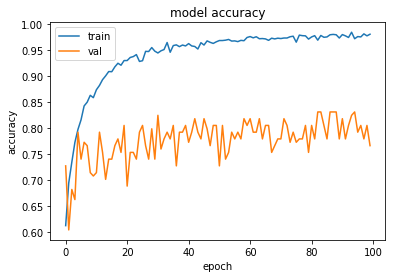

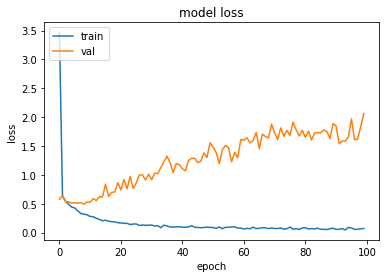

In [28]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
from sklearn.metrics import f1_score
import pandas as pd

model.load_weights('/home/aashinshazar/' + bestModelSavedName)

# get index of predicted part for each image in the test image set
part_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(part_predictions)==np.argmax(test_targets, axis=1))/len(part_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

print ("Fscore:", f1_score(np.argmax(test_targets, axis=1), part_predictions, average=None) )

y_actu = pd.Series(np.argmax(test_targets, axis=1), name='Actual')
y_pred = pd.Series(part_predictions, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

Test accuracy: 79.2727%
Fscore: [0.75744681 0.81904762]
Predicted    0    1  All
Actual                  
0           89   16  105
1           41  129  170
All        130  145  275


In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagenSlight = ImageDataGenerator(
    width_shift_range=0.1,  
    height_shift_range=0.1,
    rotation_range=3) 

datagenSlight.fit(train_tensors)

datagenUnncessary = ImageDataGenerator(
    width_shift_range=0.4,  
    height_shift_range=0.4,
    rotation_range=60,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True) 

datagenUnncessary.fit(train_tensors)


datagenAggressive = ImageDataGenerator(
    width_shift_range=0.3,  
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30) 

datagenAggressive.fit(train_tensors)

In [4]:
from keras.applications import VGG16

from keras.utils import multi_gpu_model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense

from keras import applications

numGPU = 2
image_size = 224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten(input_shape=(image_size, image_size, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
<keras.engine.input_layer.InputLayer object at 0x7f7642cf0fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f7642d0c5f8> False
<keras.layers.convolutional.Conv2D object at 0x7f7642d0c470> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7642ca2588> False
<keras.layers.convolutional.Conv2D object at 0x7f7642ca2c18> False
<keras.layers.convolutional.Conv2D object at 0x7f7642cd9b38> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7642c6cf60> False
<keras.layers.convolutional.Conv2D object at 0x7f7642c7e748> False
<keras.layers.convolutional.Conv2D object at 0x7f7642c98fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f7642c421d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7642c5a7b8> False
<keras.layers.convolutional.Conv2D object at 0x7f7642c5aba8> False
<keras.layers.convolutional.Conv2D object at 0x7f7642c039b0> False
<keras.layers.convolutional.Conv2D object at 0x7f7642c1

Epoch 1/20
72/72 [==============================] - 14s 197ms/step - loss: 6.3911 - acc: 0.5934 - val_loss: 6.6619 - val_acc: 0.5844

Epoch 00001: val_loss improved from inf to 6.66192, saving model to finalModelwAugAgg.hdf5
Epoch 2/20
72/72 [==============================] - 13s 182ms/step - loss: 1.6719 - acc: 0.5997 - val_loss: 0.6179 - val_acc: 0.6364

Epoch 00002: val_loss improved from 6.66192 to 0.61791, saving model to finalModelwAugAgg.hdf5
Epoch 3/20
72/72 [==============================] - 13s 186ms/step - loss: 0.6636 - acc: 0.6365 - val_loss: 0.6133 - val_acc: 0.6948

Epoch 00003: val_loss improved from 0.61791 to 0.61335, saving model to finalModelwAugAgg.hdf5
Epoch 4/20
72/72 [==============================] - 13s 187ms/step - loss: 0.6305 - acc: 0.6594 - val_loss: 0.5606 - val_acc: 0.7468

Epoch 00004: val_loss improved from 0.61335 to 0.56061, saving model to finalModelwAugAgg.hdf5
Epoch 5/20
72/72 [==============================] - 15s 205ms/step - loss: 0.6025 - acc:

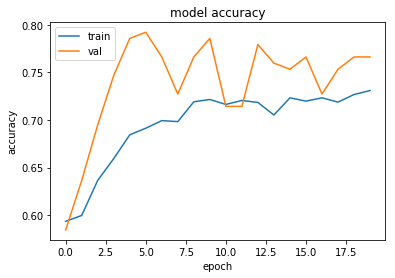

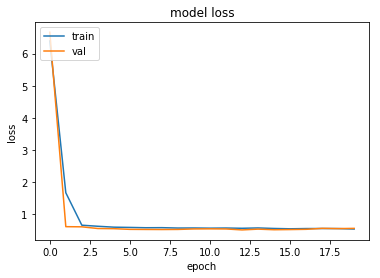

In [40]:
from keras.callbacks import ModelCheckpoint
import time

import matplotlib.pyplot as plt
import numpy

epochs = 20
batch_size=20

bestModelSavedName = "finalModelwAugAgg.hdf5"

checkpointer = ModelCheckpoint(filepath=bestModelSavedName, 
                               verbose=1, save_best_only=True)

history = model.fit_generator(datagenSlight.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [1]:
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from sklearn.metrics import f1_score
import pandas as pd
from keras.models import load_model
from PIL import ImageFile     
import cv2
import os
import math 
import pytube
import time

model.load_weights('/home/aashinshazar/finalModelwAugSlight.hdf5')

# get index of predicted part for each image in the test image set
part_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(part_predictions)==np.argmax(test_targets, axis=1))/len(part_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

print ("Fscore:", f1_score(np.argmax(test_targets, axis=1), part_predictions, average=None) )

y_actu = pd.Series(np.argmax(test_targets, axis=1), name='Actual')
y_pred = pd.Series(part_predictions, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

NameError: name 'model' is not defined

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

bigPath = '/home/aashinshazar/beta/cookiesinthejar/'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    print (data)
    part_files = np.array(sorted(glob(bigPath + "unseen/*")))
    return part_files

# load train, test, and validation datasets
unseen_files = load_dataset(bigPath + 'unseen')


print('There are %d unseen part images.' % len(unseen_files))

Using TensorFlow backend.


{'filenames': array([], dtype=float64), 'target_names': [], 'target': array([], dtype=float64), 'DESCR': None, 'data': []}
There are 350 unseen part images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
unseen_tensors = paths_to_tensor(unseen_files).astype('float32')/255

100%|██████████| 350/350 [00:01<00:00, 328.80it/s]


[[0.00215476 0.9950199 ]]
asd
[[0.00115605 0.99748355]]
asd
[[0.00476259 0.9905896 ]]
asd
[[0.00332017 0.99310863]]
asd
[[0.00313584 0.9932086 ]]
asd
[[0.00373667 0.9907177 ]]
asd


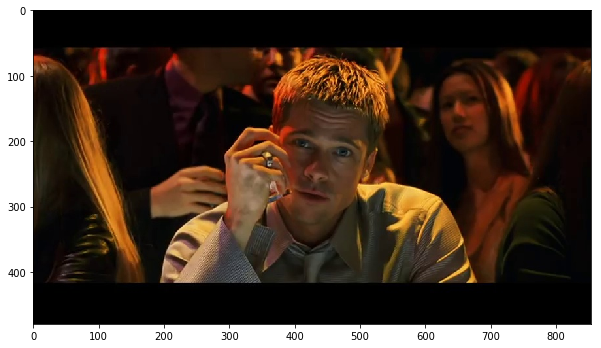

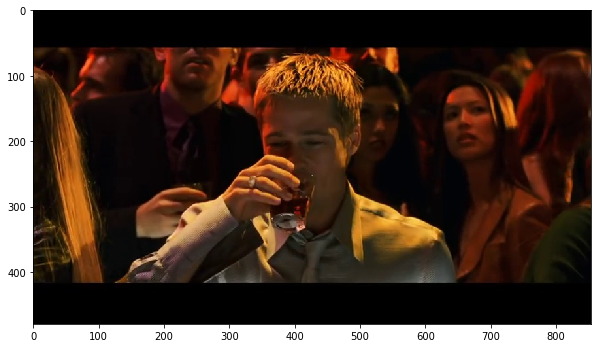

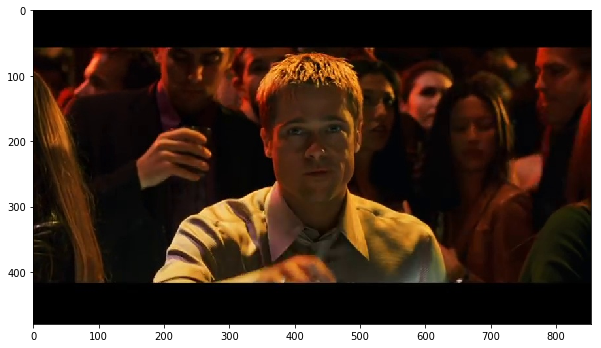

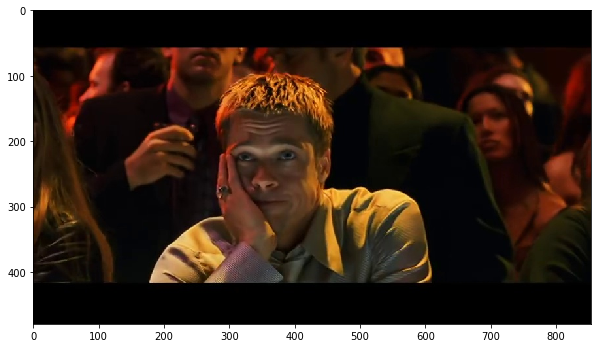

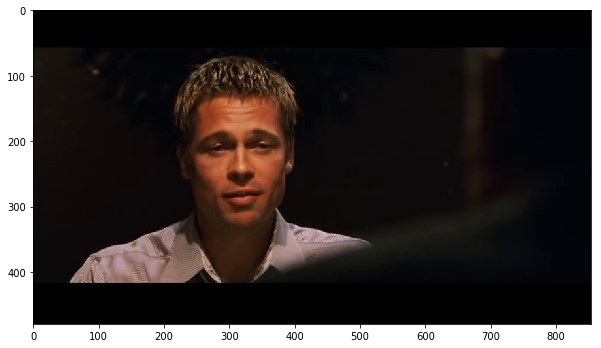

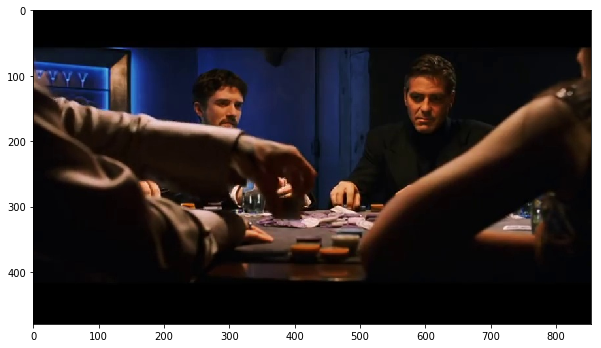

In [16]:
from sklearn.metrics import f1_score
import pandas as pd
from keras.models import load_model

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

model = load_model('/home/aashinshazar/finalModelwAugSlight.hdf5')

# get index of predicted part for each image in the test image set
part_predictions = [(model.predict(np.expand_dims(tensor, axis=0))) for tensor in unseen_tensors]

for x in range (0, 350):
    if ((part_predictions[x])[0])[1] > 0.99:
        print (part_predictions[x])
        img= mpimg.imread(unseen_files[x])
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        name=input("asd")